# HARDWARE

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

"""
To change attributes:
1) Change ATTRIBUTE and you're good to go
"""
ATTRIBUTE = 'ce_v_max'
COUNTER = '_template'
PARALLEL = 40
PARALLEL_F = 80
PARALLEL_EXTRACTION = 8
TRAIN_SIZE = 100
DEV_SIZE = 125
TEST_SIZE = 75

import os
import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')
snorkel_postgres = os.environ['SNORKELDB'].startswith('postgres')
print snorkel_postgres

True


In [2]:
import os
if snorkel_postgres:
    os.environ['SNORKELDBNAME'] = ATTRIBUTE + str(COUNTER)
    print os.system("dropdb " + os.environ['SNORKELDBNAME'])
    print os.system("createdb " + os.environ['SNORKELDBNAME'])
    print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']
else:
    try:
        os.remove('snorkel.db')
    except:
        pass

from snorkel import SnorkelSession
session = SnorkelSession()

0
0
SNORKELDBNAME = ce_v_max_template!!!


## Parsing

In [3]:
import os
if snorkel_postgres:
    from snorkel.async_parser import parse_corpus, HTMLParser, AsyncOmniParser
    print "Starting async parse..."
    
    # PARSE TRAIN
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_digikey/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_digikey/pdf/'
    doc_parser = HTMLParser()
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    %time corpus = parse_corpus(session, 'Hardware Train', docs_path,\
                                doc_parser, context_parser,\
                                max_docs=TRAIN_SIZE, parallel=PARALLEL)
    print "%s contains %d documents" % (corpus, len(corpus))
    session.commit()

    # PARSE DEV
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/pdf/'
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    %time corpus = parse_corpus(session, 'Hardware Dev', docs_path,\
                                doc_parser, context_parser,\
                                max_docs=DEV_SIZE, parallel=PARALLEL)
    print "%s contains %d documents" % (corpus, len(corpus))
    session.commit()

    if TEST_SIZE:
        # PARSE TEST
        docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/test/html/'
        pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/test/pdf/'
        context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                         tabular=True, lingual=True,
                                         visual=True, pdf_path=pdf_path)
        %time corpus = parse_corpus(session, 'Hardware Test', docs_path,\
                                    doc_parser, context_parser,\
                                    max_docs=TEST_SIZE, parallel=PARALLEL)
        print "%s contains %d documents" % (corpus, len(corpus))
        session.commit()

else:
    from snorkel.parser import CorpusParser, HTMLParser, OmniParser
    from snorkel.utils import get_ORM_instance
    from snorkel.queries import split_corpus

    print "Starting sync parse..."
    # PARSE TRAIN
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/pdf/'
    doc_parser = HTMLParser(path=docs_path)
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    cp = CorpusParser(doc_parser, context_parser, max_docs=100)

    %time corpus = cp.parse_corpus(name='Hardware Train', session=session)
    print "%s contains %d documents" % corpus, len(corpus)

    session.add(corpus)
    session.commit()
    
    # PARSE DEV
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/pdf/'
    doc_parser = HTMLParser(path=docs_path)
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                 tabular=True, lingual=True,
                                 visual=True, pdf_path=pdf_path)
    cp = CorpusParser(doc_parser, context_parser, max_docs=125)

    %time corpus = cp.parse_corpus(name='Hardware Dev', session=session)
    print "%s contains %d documents" % (corpus, len(corpus))
    session.add(corpus)
    session.commit()

Starting async parse...
[========================================] 100%
CPU times: user 268 ms, sys: 172 ms, total: 440 ms
Wall time: 41.4 s
Corpus (Hardware Train) contains 100 documents
[========================================] 100%
CPU times: user 176 ms, sys: 208 ms, total: 384 ms
Wall time: 52.4 s
Corpus (Hardware Dev) contains 122 documents
[========================================] 100%
CPU times: user 176 ms, sys: 144 ms, total: 320 ms
Wall time: 32.5 s
Corpus (Hardware Test) contains 75 documents


### Save Corpus

In [4]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [5]:
# # If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ corpus snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

In [6]:
from snorkel.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Define Matchers

In [7]:
from hardware_matchers import get_matcher

dict_path = os.environ['SNORKELHOME'] +\
    '/tutorials/tables/data/hardware/gold_raw/digikey_part_dictionary.csv'
part_matcher = get_matcher('part', dict_path)
attr_matcher = get_matcher(ATTRIBUTE)

Using combined matcher.


### Define ContextSpaces

In [8]:
from hardware_spaces import get_space
    
part_ngrams = get_space('part')
attr_ngrams = get_space(ATTRIBUTE)

### Define Candidate Throttler

In [9]:
from hardware_throttlers import get_throttler

throttler = get_throttler(ATTRIBUTE)
# throttler = None

### Run CandidateExtractor

In [10]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance
from snorkel.async_candidates import parallel_extract

ce = CandidateExtractor(Part_Attr,
                        [part_ngrams, attr_ngrams],
                        [part_matcher, attr_matcher],
                        throttler=throttler)

corpus_names = ['Hardware Train', 'Hardware Dev']
if TEST_SIZE:
    corpus_names.append('Hardware Test')
for corpus_name in corpus_names:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = parallel_extract(session, ce, corpus, \
                                        corpus_name + ' Candidates', \
                                        parallel=PARALLEL_EXTRACTION)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

Extracting Candidates from Corpus (Hardware Train)
[========================================] 100%
CPU times: user 404 ms, sys: 256 ms, total: 660 ms
Wall time: 7min 31s
Candidate Set (Hardware Train Candidates) contains 12271 Candidates
Extracting Candidates from Corpus (Hardware Dev)
[========================================] 100%
CPU times: user 464 ms, sys: 292 ms, total: 756 ms
Wall time: 10min 5s
Candidate Set (Hardware Dev Candidates) contains 42537 Candidates
Extracting Candidates from Corpus (Hardware Test)
[========================================] 100%
CPU times: user 300 ms, sys: 188 ms, total: 488 ms
Wall time: 5min 36s
Candidate Set (Hardware Test Candidates) contains 6714 Candidates


### Second Pass

In [11]:
# from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
# from snorkel.utils import get_ORM_instance
# from snorkel.models import Corpus

# corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')

# # parts_by_doc = get_gold_parts_by_doc()
# parts_by_doc = get_manual_parts_by_doc(corpus.documents.all())
# # parts_by_doc = None

In [12]:
# import cPickle as pickle
# pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc_dev.pkl'

# with open(pickle_file, 'w') as f:
#     pickle.dump(parts_by_doc, f)

In [13]:
import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc_dev.pkl'
with open(pickle_file, 'r') as f:
    parts_by_doc = pickle.load(f)

### Assess Recall

In [14]:
from snorkel.models import Corpus, CandidateSet
from hardware_utils import entity_level_f1

corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')
candidates = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
gold_file = os.environ['SNORKELHOME'] + \
    '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
%time (ctp, cfp, cfn) = entity_level_f1(candidates, gold_file, ATTRIBUTE, corpus, parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.106
Corpus Recall    0.908
Corpus F1        0.189
----------------------------------------
TP: 783 | FP: 6620 | FN: 79

CPU times: user 50.1 s, sys: 652 ms, total: 50.8 s
Wall time: 56 s


In [15]:
from pprint import pprint
pprint(cfp)

[(u'112823', u'BC546', u'110'),
 (u'112823', u'BC546', u'450'),
 (u'112823', u'BC546', u'80'),
 (u'112823', u'BC546B', u'110'),
 (u'112823', u'BC546B', u'150'),
 (u'112823', u'BC546B', u'180'),
 (u'112823', u'BC546B', u'200'),
 (u'112823', u'BC546B', u'220'),
 (u'112823', u'BC546B', u'290'),
 (u'112823', u'BC546B', u'450'),
 (u'112823', u'BC546B', u'80'),
 (u'112823', u'BC546B', u'800'),
 (u'112823', u'BC546BG', u'110'),
 (u'112823', u'BC546BG', u'150'),
 (u'112823', u'BC546BG', u'180'),
 (u'112823', u'BC546BG', u'200'),
 (u'112823', u'BC546BG', u'220'),
 (u'112823', u'BC546BG', u'290'),
 (u'112823', u'BC546BG', u'450'),
 (u'112823', u'BC546BG', u'80'),
 (u'112823', u'BC546BG', u'800'),
 (u'112823', u'BC546BRL1', u'110'),
 (u'112823', u'BC546BRL1', u'150'),
 (u'112823', u'BC546BRL1', u'180'),
 (u'112823', u'BC546BRL1', u'200'),
 (u'112823', u'BC546BRL1', u'220'),
 (u'112823', u'BC546BRL1', u'290'),
 (u'112823', u'BC546BRL1', u'450'),
 (u'112823', u'BC546BRL1', u'80'),
 (u'112823', u'BC

In [16]:
pprint(cfn)

[('CENTRALSEMICONDUCTORCORP_CENU45', 'CEN-U45', '40'),
 ('CENTRALSEMICONDUCTORCORP_CMPT5401ETR', 'CMPT5401E', '220'),
 ('DIODESINCORPORATED_2DD26527', '2DD2652', '12'),
 ('DIODESINCORPORATED_2DD26527', '2DD2652-7', '12'),
 ('DIODESINCORPORATED_ZTX688BSTZ', 'ZTX688B', '12'),
 ('DIODS13249-1', 'BC817-40', '45'),
 ('DIODS13249-1', 'BC818-40', '25'),
 ('DISES00189-1', 'BC546B', '65'),
 ('DISES00189-1', 'BC547B', '45'),
 ('DISES00189-1', 'BC548B', '30'),
 ('DISES00189-1', 'BC549B', '30'),
 ('DISES00490-1', 'BC846AW', '65'),
 ('DISES00490-1', 'BC846BW', '65'),
 ('DISES00490-1', 'BC847AW', '45'),
 ('DISES00490-1', 'BC847BW', '45'),
 ('DISES00490-1', 'BC847CW', '45'),
 ('DISES00490-1', 'BC848AW', '30'),
 ('DISES00490-1', 'BC848BW', '30'),
 ('DISES00490-1', 'BC848CW', '30'),
 ('DISES00490-1', 'BC849BW', '30'),
 ('DISES00490-1', 'BC849CW', '30'),
 ('KECCS03676-1', 'BC858A', '30'),
 ('KECCS03676-1', 'BC858B', '30'),
 ('LITES00689-1', 'BC337-16', '45'),
 ('LITES00689-1', 'BC337-25', '45'),
 ('LITE

In [17]:
# for c in candidates:
#     if c[0].parent.document.name == '2N3906':
#         print c

In [18]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [19]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

In [20]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

data_sets = ['Dev']
gold_file = {}
gold_file['Dev'] = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
if TEST_SIZE:
    data_sets.append('Test')
    gold_file['Test'] = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/test/hardware_test_gold.csv'
for data_set in data_sets:
    candidate_set_name = 'Hardware %s Candidates' % data_set
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % data_set
    annotation_key_name = 'Hardware %s Labels -- Gold' % data_set
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file[data_set], \
                           ATTRIBUTE)
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

Loading 42537 candidate labels
[========================================] 100%
CPU times: user 1min, sys: 988 ms, total: 1min 1s
Wall time: 1min 7s
6458/42537 Candidates in Candidate Set (Hardware Dev Candidates) have positive Labels
Loading 6714 candidate labels
[========================================] 100%
CPU times: user 13.6 s, sys: 200 ms, total: 13.8 s
Wall time: 15.2 s
1583/6714 Candidates in Candidate Set (Hardware Test Candidates) have positive Labels


In [21]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [22]:
# # If necessary:
# import os
# # os.remove('snorkel.db');
# os.system('cp snorkel.db\ labels snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

In [23]:
from snorkel.models import CandidateSet
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Train Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
test  = get_ORM_instance(CandidateSet, session, 'Hardware Test Candidates')

### Extract Features

In [24]:
# from snorkel.models import CandidateSet
# from snorkel.utils import get_ORM_instance

# train = get_ORM_instance(CandidateSet, session, 'Hardware Train Candidates')
# dev   = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
# test  = get_ORM_instance(CandidateSet, session, 'Hardware Test Candidates')

if snorkel_postgres:
    from snorkel.async_annotations import annotate
    print "Starting async featurization..."
    %time F_train = annotate(train, parallel=PARALLEL_F)
#     %time F_train = annotate(train, parallel=PARALLEL, dynamic_scheduling=True)
    %time F_dev   = annotate(dev, parallel=PARALLEL_F, \
                             keyset = 'Hardware Train Candidates')
    if TEST_SIZE:
        %time F_test = annotate(test, parallel=PARALLEL_F, dynamic_scheduling=False,\
                                keyset = 'Hardware Train Candidates')
    
else:
    from snorkel.models import CandidateSet
    from snorkel.fast_annotations import FeatureManager
    from snorkel.utils import get_ORM_instance

    print "Starting sync featurization..."
    feature_manager = FeatureManager()
    %time F_train = feature_manager.create(session, train, 'Train Features')
    %time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

Starting async featurization...
[========================================] 100%
Copying hardware_train_candidates_features to postgres
COPY 12271

CPU times: user 41.7 s, sys: 756 ms, total: 42.5 s
Wall time: 6min 21s
[========================================] 100%
Copying hardware_dev_candidates_features to postgres
COPY 42537

CPU times: user 2min 17s, sys: 1.3 s, total: 2min 18s
Wall time: 27min 47s
[========================================] 100%
Copying hardware_test_candidates_features to postgres
COPY 6714

CPU times: user 14.8 s, sys: 1.12 s, total: 16 s
Wall time: 3min 57s


In [25]:
# If necessary:
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [26]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ featurized snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Train Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Dev Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

### Define LFs

In [27]:
from hardware_lfs import get_lfs

LFs = get_lfs(ATTRIBUTE)

### Apply LFs

In [31]:
if snorkel_postgres:
    from snorkel.async_annotations import annotate
    %time L_train = annotate(train, parallel=PARALLEL_F, lfs=LFs)
#     %time L_train = annotate(train, parallel=PARALLEL, lfs=LFs, dynamic_scheduling=True)
else:
    from snorkel.fast_annotations import LabelManager
    label_manager = LabelManager()
    %time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%
Copying hardware_train_candidates_labels to postgres
COPY 12271

CPU times: user 2.28 s, sys: 896 ms, total: 3.17 s
Wall time: 4min 55s


<12271x12 sparse matrix of type '<type 'numpy.float32'>'
	with 19051 stored elements in Compressed Sparse Row format>

### Assess LF accuracy

In [32]:
%time L_train.lf_stats()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.18 ms


,conflicts,coverage,j,overlaps
LF_part_complement,0.0,0.000000,0,0.000000
LF_part_ce_keywords_in_col_prefix_same_table,0.0,0.001304,1,0.000000
LF_part_ce_keywords_in_row_prefix_same_table,0.0,0.000000,2,0.000000
LF_many_p_siblings,0.0,0.000000,3,0.000000
LF_voltage_not_in_table,0.0,0.000000,4,0.000000
LF_bad_keywords_in_row,0.0,0.325972,5,0.325564
LF_part_miss_match,0.0,0.000489,6,0.000489
LF_replacement_table,0.0,0.000000,7,0.000000
LF_current_in_row,0.0,0.529949,8,0.378779
LF_please_to_left,0.0,0.000000,9,0.000000


In [33]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [34]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ features snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

# label_manager = LabelManager()
# %time L_train = label_manager.load(session, train, 'LF Labels')

In [35]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
%time gen_model.train(L_train, n_iter=2000, rate=1e-3)
train_marginals = gen_model.marginals(L_train)

/home/ubuntu/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	12271
Features:			12
Begin training for rate=0.001, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.580499
	Learning epoch = 250	Gradient mag. = 0.646474
	Learning epoch = 500	Gradient mag. = 0.681178
	Learning epoch = 750	Gradient mag. = 0.714968
	Learning epoch = 1000	Gradient mag. = 0.747738
	Learning epoch = 1250	Gradient mag. = 0.779444
	Learning epoch = 1500	Gradient mag. = 0.810098
	Learning epoch = 1750	Gradient mag. = 0.839749
Final gradient magnitude for rate=0.001, mu=1e-06: 0.868
CPU times: user 5.84 s, sys: 0 ns, total: 5.84 s
Wall time: 5.82 s


In [36]:
pprint(zip([lf.__name__ for lf in LFs], gen_model.w))
print min(train_marginals)
print max(train_marginals)

[('LF_cheating_with_another_part', 0.99700150024917644),
 ('LF_replacement_table', 0.99700150024784462),
 ('LF_many_p_siblings', 0.99700150024917644),
 ('LF_part_complement', 0.99700150024917644),
 ('LF_please_to_left', 0.99700150024917644),
 ('LF_voltage_not_in_table', 1.9996925644235428),
 ('LF_bad_keywords_in_row', 0.99832112964734698),
 ('LF_current_in_row', 0.99700150024917644),
 ('LF_non_ce_voltages_in_row', 1.7395099888601404),
 ('LF_part_ce_keywords_in_row_prefix_same_table', 0.99700150024917644),
 ('LF_part_ce_keywords_in_col_prefix_same_table', 1.0863108062295079),
 ('LF_part_miss_match', 1.802554228855703)]
0.0013209693828
0.730468629505


In [37]:
from snorkel.learning import LogReg

disc_model = LogReg()
%time disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-3)

Training marginals (!= 0.5):	10003
Features:			17916
Using gradient descent...
	Learning epoch = 0	Step size = 0.001
	Loss = 6933.551247	Gradient magnitude = 23352.586645
	Learning epoch = 100	Step size = 0.000904792147114
	Loss = 27568.479017	Gradient magnitude = 19512.724272
	Learning epoch = 200	Step size = 0.000818648829479
	Loss = 20003.136706	Gradient magnitude = 4474.229896
	Learning epoch = 300	Step size = 0.000740707032156
	Loss = 20003.136809	Gradient magnitude = 4474.229896
	Learning epoch = 400	Step size = 0.000670185906007
	Loss = 17714.057534	Gradient magnitude = 4473.031963
	Learning epoch = 500	Step size = 0.000606378944861
	Loss = 5940.277275	Gradient magnitude = 3409.988423
	Learning epoch = 600	Step size = 0.000548646907485
	Loss = 19940.843403	Gradient magnitude = 4474.229896
	Learning epoch = 700	Step size = 0.000496411413431
	Loss = 18034.804442	Gradient magnitude = 4474.099163
	Learning epoch = 800	Step size = 0.00044914914861
	Loss = 4377.106958	Gradient magnitu

In [38]:
dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Dev Candidates -- Gold').one()

In [39]:
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Dev Labels -- Gold')
L_dev.shape

(42537, 1)

Calibration plot:


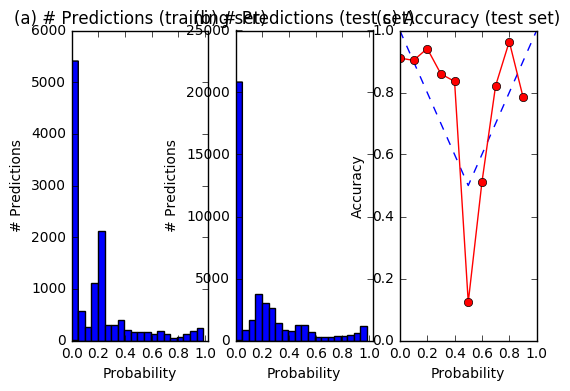

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.432022297925
Neg. class accuracy: 0.979849774107
Corpus Precision 0.793
Corpus Recall    0.432
Corpus F1        0.559
----------------------------------------
TP: 2790 | FP: 727 | TN: 35352 | FN: 3668

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.216011148963
Neg. class accuracy: 0.979849774107
Corpus Precision 0.793
Corpus Recall    0.216
Corpus F1        0.34
----------------------------------------
TP: 2790 | FP: 727 | TN: 35352 | FN: 10126



In [63]:
tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold, b=0.6)

In [64]:
from snorkel.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Dev').one()
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc=None)
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc=parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.782
Corpus Recall    0.691
Corpus F1        0.734
----------------------------------------
TP: 596 | FP: 166 | FN: 266

CPU times: user 460 ms, sys: 80 ms, total: 540 ms
Wall time: 421 ms
Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.732
Corpus Recall    0.876
Corpus F1        0.798
----------------------------------------
TP: 755 | FP: 276 | FN: 107

CPU times: user 556 ms, sys: 76 ms, total: 632 ms
Wall time: 483 ms


In [42]:
for i in FP:
    print i

(u'2N6427', u'MPSA14', u'40')
(u'AUKCS04635-1', u'2N3906', u'625')
(u'BC182-D', u'BC182', u'500')
(u'BC182-D', u'BC182B', u'500')
(u'BC182-D', u'BC182BG', u'500')
(u'BC182-D', u'BC182BRL1G', u'500')
(u'BC182-D', u'BC182G', u'500')
(u'BC337', u'BC337', u'150')
(u'BC337', u'BC337', u'50')
(u'BC337', u'BC337-16', u'150')
(u'BC337', u'BC337-16', u'50')
(u'BC337', u'BC337-25', u'150')
(u'BC337', u'BC337-25', u'50')
(u'BC337', u'BC337-40', u'150')
(u'BC337', u'BC337-40', u'50')
(u'BC337', u'BC33716BU', u'150')
(u'BC337', u'BC33716BU', u'50')
(u'BC337', u'BC33716TA', u'150')
(u'BC337', u'BC33716TA', u'50')
(u'BC337', u'BC33716TFR', u'150')
(u'BC337', u'BC33716TFR', u'50')
(u'BC337', u'BC33725BU', u'150')
(u'BC337', u'BC33725BU', u'50')
(u'BC337', u'BC33725TA', u'150')
(u'BC337', u'BC33725TA', u'50')
(u'BC337', u'BC33725TAR', u'150')
(u'BC337', u'BC33725TAR', u'50')
(u'BC337', u'BC33725TF', u'150')
(u'BC337', u'BC33725TF', u'50')
(u'BC337', u'BC33725TFR', u'150')
(u'BC337', u'BC33725TFR', u'50

### Error Analysis

In [43]:
# from hardware_utils import separate_fns

# unfound, misclassified = separate_fns(FN, cfn)

In [44]:
# pprint(misclassified)

In [45]:
# pprint(unfound)

In [46]:
# from hardware_utils import separate_fps

# bad_part, bad_relation = separate_fps(FP, corpus, gold_file)

In [47]:
# pprint(bad_relation)

In [48]:
# pprint(bad_part)

In [49]:
# from pprint import pprint
# pprint([(unicode(x[0]), x[1]) for x in disc_model.get_feature_weights(F_dev)[:100]])

In [50]:
# from hardware_utils import entity_to_candidates

# entity = FP[0]
# print entity
# print

# matches = entity_to_candidates(entity, fp)
# print "# Matches: %d" % len(matches)
# print

# candidate = matches[0]
# print candidate
# print

# from hardware_utils import part_error_analysis
# part_error_analysis(candidate)

# pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

### Oracle

In [51]:
from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
from snorkel.utils import get_ORM_instance
from snorkel.models import Corpus

parts_by_doc = get_gold_parts_by_doc()
(TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.467
Corpus Recall    0.893
Corpus F1        0.613
----------------------------------------
TP: 770 | FP: 879 | FN: 92



### Test Results

Calibration plot:


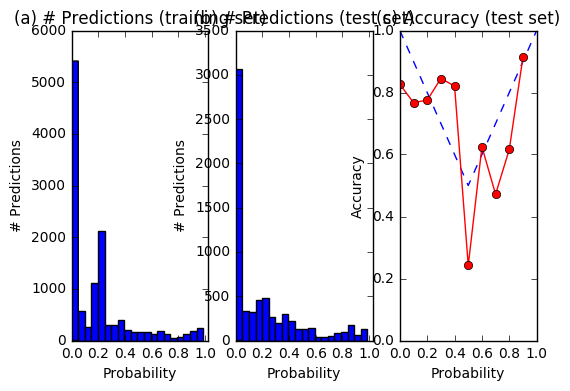

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.275426405559
Neg. class accuracy: 0.95614889885
Corpus Precision 0.66
Corpus Recall    0.275
Corpus F1        0.389
----------------------------------------
TP: 436 | FP: 225 | TN: 4906 | FN: 1147

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.0542221116777
Neg. class accuracy: 0.95614889885
Corpus Precision 0.66
Corpus Recall    0.0542
Corpus F1        0.1
----------------------------------------
TP: 436 | FP: 225 | TN: 4906 | FN: 7605

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.641
Corpus Recall    0.704
Corpus F1        0.671
----------------------------------------
TP: 107 | FP: 60 | FN: 45

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.646
Corpus Recall    0.743
Corpus F1        0.691
----------------------------------------
TP: 113 | FP: 62 | FN: 39



In [65]:
if TEST_SIZE:
    from snorkel.annotations import LabelManager
    label_manager = LabelManager()
    L_test = label_manager.load(session, test, 'Hardware Test Labels -- Gold')
    L_test.shape
    
    tp, fp, tn, fn = disc_model.score(F_test, L_test, dev_gold,b=0.6)
    
    from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
    from snorkel.utils import get_ORM_instance
    from snorkel.models import Corpus

    corpus = get_ORM_instance(Corpus, session, 'Hardware Test')

    # parts_by_doc_test = get_manual_parts_by_doc(corpus.documents.all())
    # parts_by_doc_test = None
    import cPickle as pickle
    pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc_test.pkl'
    with open(pickle_file, 'r') as f:
        parts_by_doc_test = pickle.load(f)

    from snorkel.models import Corpus
    from hardware_utils import entity_level_f1
    import os

    gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/test/hardware_test_gold.csv'
    (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus)
    (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc_test)